# Self Data Analysis 1  

Titanic Dataset from: https://www.kaggle.com/competitions/titanic/data?select=train.csv   
This is round 2 after linear regression didn't work well.   
Arush Bodla

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## EDA

In [2]:
data = pd.read_csv("data/titanic_train.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


I'm going to remove all of the columns with fully unique values since they wouldn't be of much use. I'll also do some preprocessing.

In [5]:
data.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], errors="ignore", inplace=True)
data.dropna(inplace=True)
encoder = OrdinalEncoder()
for col in data.select_dtypes("object").columns:
    data[col] = encoder.fit_transform(data[[col]])

0.4044943820224719


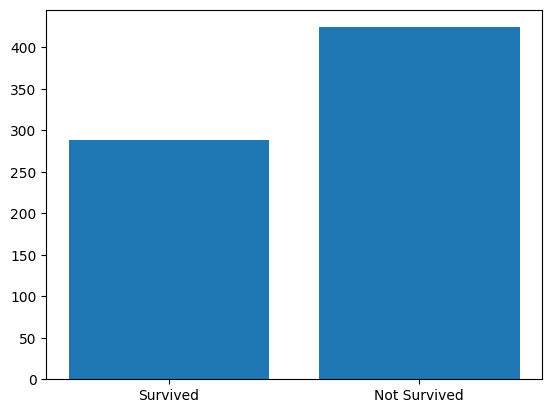

In [6]:
survived = data[data["Survived"] == 1]
not_survived = data[data["Survived"] == 0]
plt.bar(["Survived", "Not Survived"], [survived.shape[0], not_survived.shape[0]])
print(np.mean(data["Survived"]))
np.random.seed(102)

About 40% of the people survived, which means the data is somewhat balanced. I'll see if there's any colinearity in the data.


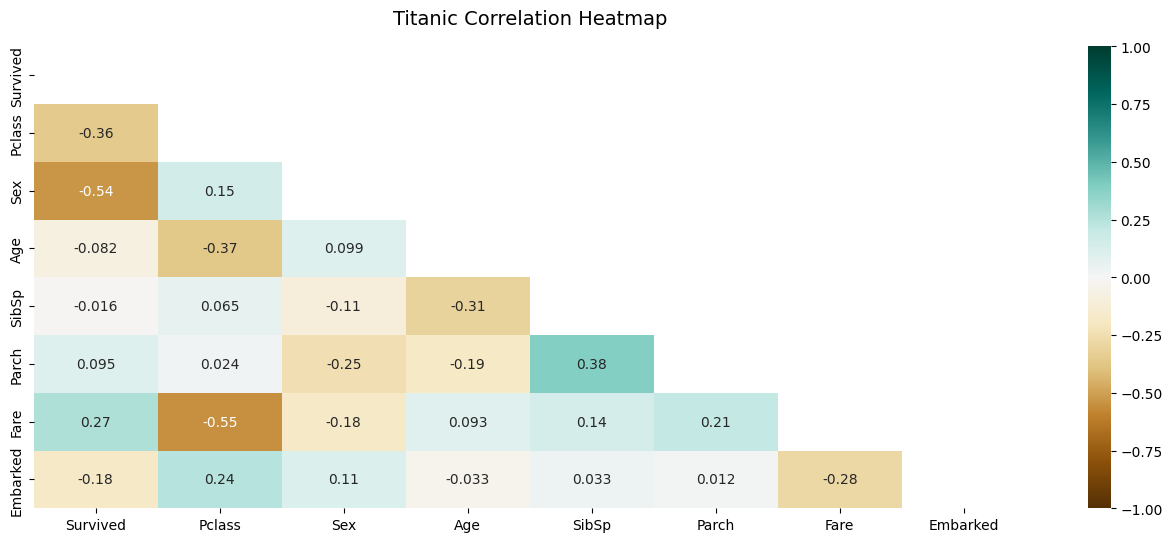

In [7]:
corr_matrix = data.corr()
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))
heatmap = sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Titanic Correlation Heatmap', fontdict={'fontsize':14}, pad=16);
plt.show()

There's not much colinearity, so i'll leave the columns in. I'll plot Pclass vs Fare and Survived vs Sex, to see if the correlation is strong.

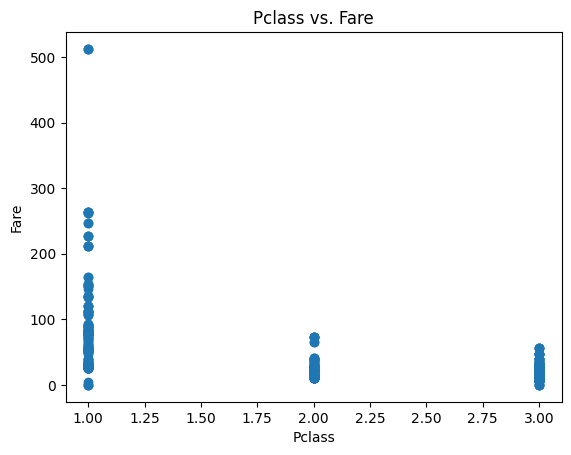

In [8]:
plt.scatter(data["Pclass"], data["Fare"])
plt.xlabel("Pclass")
plt.ylabel("Fare")
plt.title("Pclass vs. Fare")
plt.show()

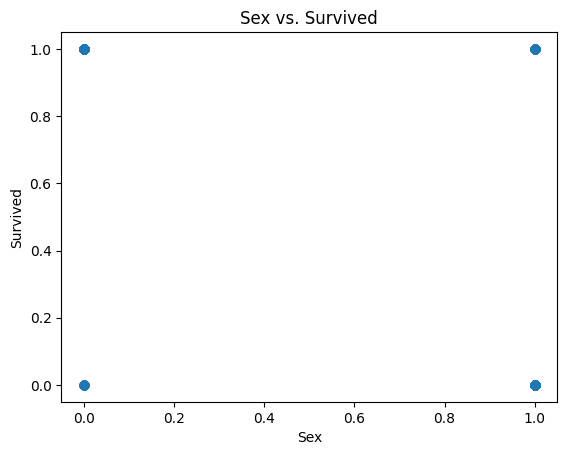

In [9]:
plt.scatter(data["Sex"], data["Survived"])
plt.xlabel("Sex")
plt.ylabel("Survived")
plt.title("Sex vs. Survived")
plt.show()

Plotting these didn't really produce anything useful, except the one outlier in the fare. I'll just leave the data as-is since I can't conclude much.

## Helper Methods

In [ ]:
def accuracy(model, X_test, y_test):
    cm = confusion_matrix(y_test, model.predict(X_test))
    return (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1])

In [93]:
#colormaps so that higher values are good(green) for main diagonal and bad(red) for the off diagonal
#red = (1, 0.4, 0.4)
#green = (0.4, 1, 0.4)
red = (0.6, 0, 0)
green = (0, 0.6, 0)
main_diag_cmap = LinearSegmentedColormap.from_list("main_diag", [red, (1, 1, 1), green]) 
off_diag_cmap = LinearSegmentedColormap.from_list("off_diag", [green, (1, 1, 1), red])
def plot_confusion_comparison(cm1, cm2, ax, colorbar_message, hide_bottom=False, hide_side=False, colorbar=True, extra_labels=True):
    diff = cm2 - cm1
    
    main_diag_mask = np.eye(2, dtype=bool)
    off_diag_mask = ~main_diag_mask
    
    max_abs_diff = np.abs(diff).max()
    vmin, vmax = -15, 15
    
    sns.heatmap(
        diff,
        mask=off_diag_mask, cmap=main_diag_cmap,
        annot=True, fmt="+d",
        cbar=colorbar,
        cbar_kws={"label": colorbar_message},  
        linewidths=0.5,
        ax=ax, 
        vmin=vmin, vmax=vmax,
        xticklabels=not hide_bottom, yticklabels=not hide_side
    )
    sns.heatmap(
        diff,
        mask=main_diag_mask, cmap=off_diag_cmap,
        annot=True, fmt="+d",
        cbar=False,
        linewidths=0.5,
        ax=ax,
        vmin=vmin, vmax=vmax,
        xticklabels=not hide_bottom, yticklabels=not hide_side
    )
    
    
    if(not hide_bottom):
        ax.set_xticklabels(["Died", "Survived"])
    
    if not hide_side:
        ax.set_yticklabels(["Died", "Survived"])
    
    if extra_labels:
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
    else:
        ax.tick_params(length=0)

## Testing Various Models

In [12]:
X = data.drop(columns=["Survived"])
y = data["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102)

### K nearest neighbors

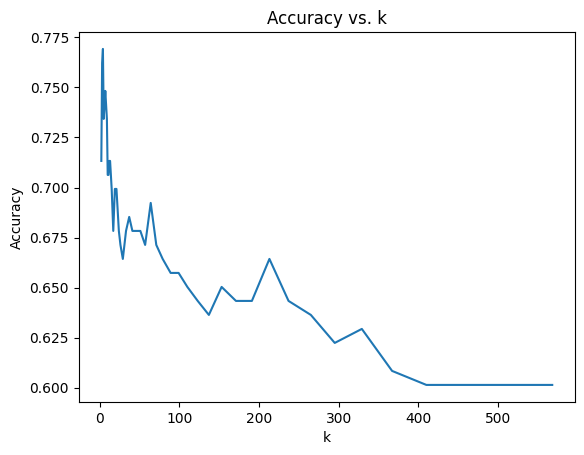

Best k: 4 
Accuracy: 0.7692307692307693


In [13]:
model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train, y_train)

k_values = np.unique(np.logspace(1, np.log(X_train.shape[0]), 50, base=np.e)).astype(int)
scores = []
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    scores.append(accuracy(model, X_test, y_test))
    
plt.title("Accuracy vs. k")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.plot(k_values, scores)
plt.show()
print("Best k:", k_values[np.argmax(scores)], "\nAccuracy:", np.max(scores))
knnbestk = k_values[np.argmax(scores)]

It looks like k=4 is the best amount, but the model is not that great. I'll see if other parameters can make it better.

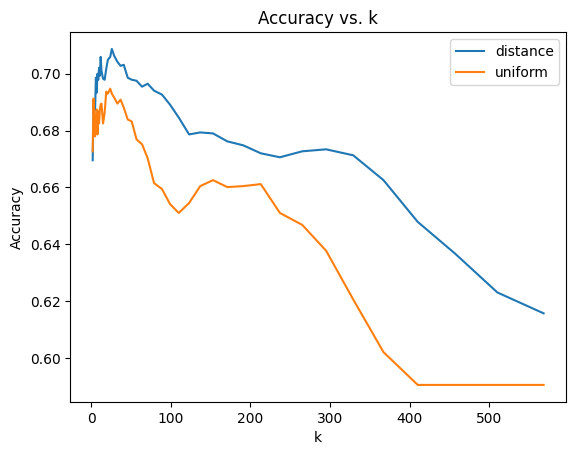

In [14]:
seednum = 102
def test_distance_uniform():
    global seednum
    scored = []
    scoreu = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seednum)
    seednum += 1
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k, weights="distance")
        model.fit(X_train, y_train)
        scored.append(accuracy(model, X_test, y_test))
        model = KNeighborsClassifier(n_neighbors=k, weights="uniform")
        model.fit(X_train, y_train)
        scoreu.append(accuracy(model,X_test, y_test))
    return np.array(scored), np.array(scoreu)

scoredtotal = np.zeros(len(k_values))
scoreutotal = np.zeros(len(k_values))
for i in range(20):
    scored, scoreu = test_distance_uniform()
    scoredtotal += scored
    scoreutotal += scoreu
    
scored = scoredtotal / (20)
scoreu = scoreutotal / (20)

plt.title("Accuracy vs. k")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.plot(k_values, scored, label="distance")
plt.plot(k_values, scoreu, label="uniform")
plt.legend()
plt.show()

In [15]:
print("Best k (distance):", k_values[np.argmax(scored)], "\nAccuracy:", np.max(scored))
print("Best k (uniform):", k_values[np.argmax(scoreu)], "\nAccuracy:", np.max(scoreu))

Best k (distance): 26 
Accuracy: 0.7087412587412586
Best k (uniform): 24 
Accuracy: 0.6947552447552447


Looks like distance is the better option. Also, the original test train split looks like it was very forgiving to the model, since the average of 20 splits tank the accuracy down a few percent.

Brute Force: 0.7552447552447552
KD Tree: 0.7552447552447552
Ball Tree: 0.7552447552447552


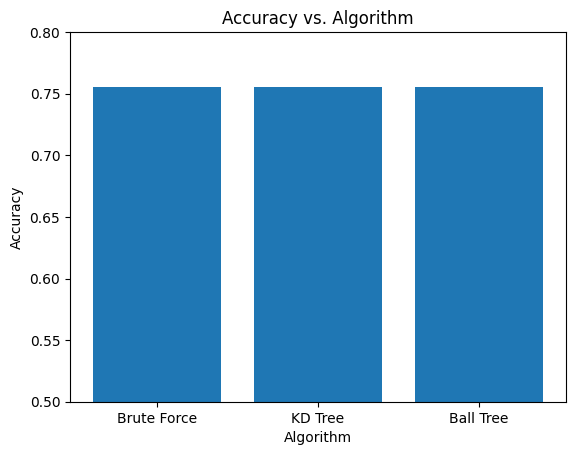

In [16]:
model = KNeighborsClassifier(n_neighbors=knnbestk, weights="distance", algorithm="brute")
model.fit(X_train, y_train)
brute = accuracy(model, X_test, y_test)

model = KNeighborsClassifier(n_neighbors=knnbestk, weights="distance", algorithm="kd_tree")
model.fit(X_train, y_train)
kd_tree = accuracy(model, X_test, y_test)

model = KNeighborsClassifier(n_neighbors=knnbestk, weights="distance", algorithm="ball_tree")
model.fit(X_train, y_train)
ball_tree = accuracy(model, X_test, y_test)

print("Brute Force:", brute)
print("KD Tree:", kd_tree)
print("Ball Tree:", ball_tree)

plt.title("Accuracy vs. Algorithm")
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.bar(["Brute Force", "KD Tree", "Ball Tree"], [brute, kd_tree, ball_tree])
plt.ylim(0.5, 0.8)
plt.show()

They're the exact same, so I'll leave the algorithm at auto. The final KNN classifier is below:

In [17]:
model = KNeighborsClassifier(n_neighbors=knnbestk, weights="distance", algorithm="auto")
model.fit(X_train, y_train)
print("Accuracy: ", accuracy(model, X_test, y_test))

Accuracy:  0.7552447552447552


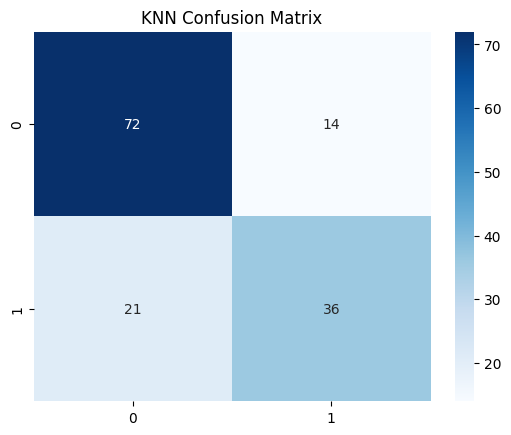

In [18]:
cm_knn = confusion_matrix(y_test, model.predict(X_test))

plt.title("KNN Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
sns.heatmap(cm_knn, annot=True, cmap="Blues")
plt.show()

That's a decent imrovement over linear regression, about 5-6% more. (For context, the linear regression model got 68% accuracy.) As for the correlation matrix, I don't have anything to go off yet, so I'm assuming the model is doing well.

### Logistic Regression

In [19]:
model = LogisticRegression(max_iter=1000, random_state=102) #arbitrary for convergence
model.fit(X_train, y_train)
print("Accuracy: ", accuracy(model, X_test, y_test))

Accuracy:  0.8251748251748252


This is much better than KNN, without even setting any parameters. I'll look at the max iterations first.

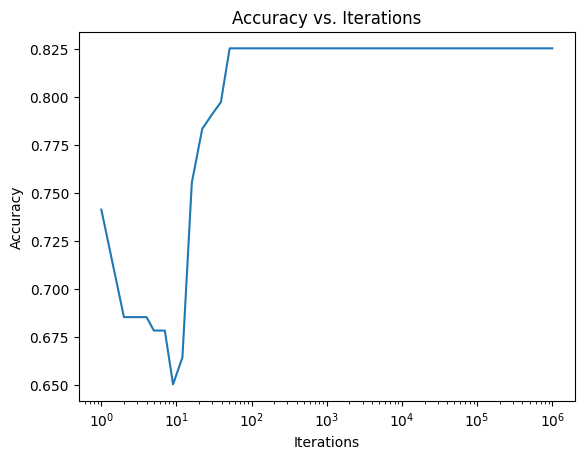

In [20]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
#suppress convergence warnings


iters = np.unique(np.logspace(0, 6, 50, base=10)).astype(int)
acc = []


for i in iters:
    model = LogisticRegression(max_iter=i, random_state=102)
    model.fit(X_train, y_train)
    acc.append(accuracy(model, X_test, y_test))

plt.title("Accuracy vs. Iterations")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.plot(iters, acc)
plt.show()

In [21]:
bestiter = iters[np.argmax(acc)]
print("Best iterations:", bestiter, "\nAccuracy:", np.max(acc))

Best iterations: 51 
Accuracy: 0.8251748251748252


The best number of iterations is around 50, and it flatlines towards the end. I'll try the different penalty parameter and solver combinations next.

Best Accuracy: 0.8391608391608392
Best Solver: newton-cg
Best Penalty: l2
Best Iterations: 16


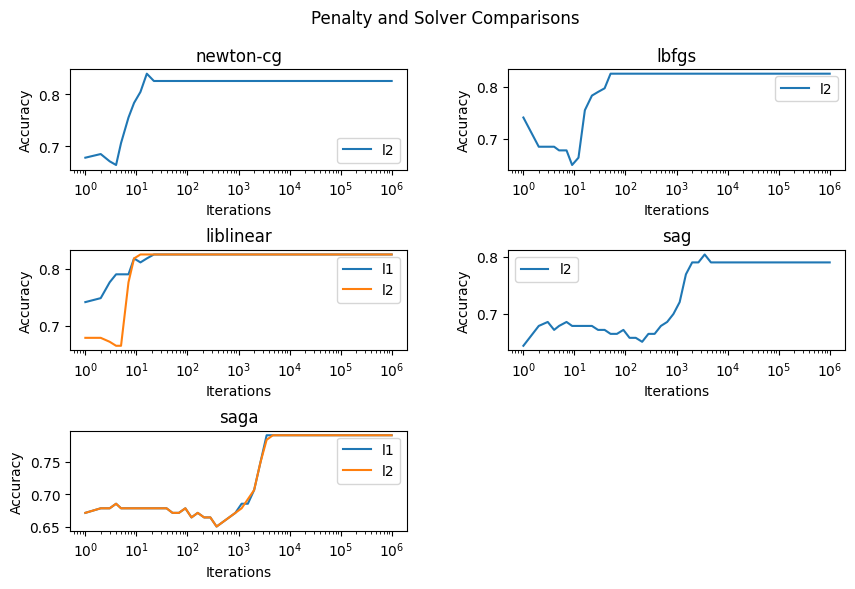

In [22]:
solvers = {'newton-cg': ['l2'], 'lbfgs' : ['l2'], 'liblinear': ['l1', 'l2'], 'sag':['l2'], 'saga': ['l1', 'l2']}

fig, axes = plt.subplots(3, 2, figsize=(10, 6))
axes = axes.ravel()
axes[-1].set_visible(False)

fig.subplots_adjust(hspace=0.8, wspace=0.3)
fig.suptitle("Penalty and Solver Comparisons")

max_acc = 0
best_solver = ""
best_penalty = ""
best_iter = 0


for i, (solver, penalties) in enumerate(solvers.items()):
    ax = axes[i]
    ax.set_title(solver)
    ax.set_xscale("log")
    for penalty in penalties:
        acc = []
        for iter in iters:
            model = LogisticRegression(penalty=penalty, solver=solver, max_iter=iter, random_state=102)
            model.fit(X_train, y_train)
            a = accuracy(model, X_test, y_test)
            acc.append(a)
            if(a > max_acc) or (a == max_acc and iter < best_iter):
                max_acc = a
                best_solver = solver
                best_penalty = penalty
                best_iter = iter
        ax.plot(iters, acc, label=penalty)
    ax.legend()
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Iterations", fontsize=10)
print("Best Accuracy:", max_acc)
print("Best Solver:", best_solver)
print("Best Penalty:", best_penalty)
print("Best Iterations:", best_iter)
plt.show()

The best combination looks like it's newton-cg with l2 regression. The accuracy is 84% identified correctly, and it's much better than linear regression and KNN. The final model is below:

Accuracy:  0.8391608391608392


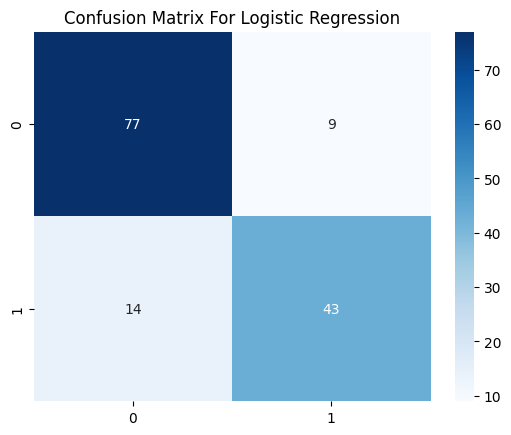

In [23]:
model = LogisticRegression(penalty=best_penalty, solver=best_solver, max_iter=best_iter, random_state=102)
model.fit(X_train, y_train)
print("Accuracy: ", accuracy(model, X_test, y_test))
cm_log = confusion_matrix(y_test, model.predict(X_test))

plt.title("Confusion Matrix For Logistic Regression")
sns.heatmap(cm_log, annot=True, cmap="Blues")
plt.show()

Comparisons between the two model as a difference heatmap is below:   
green values mean the logistic regression model did better, red means the KNN model did better. The numbers show how many cases the two models differed by.

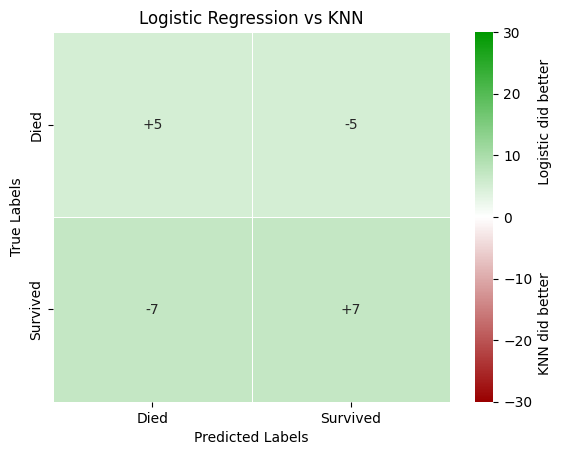

In [24]:
fig, ax = plt.subplots()
ax.set_title("Logistic Regression vs KNN")
plot_confusion_comparison(cm_knn, cm_log, ax, "KNN did better                    Logistic did better")
plt.show()

It looks like the logistic regression outperformed KNN in all cases.

### Decision Trees

In [25]:
model = DecisionTreeClassifier(random_state=102)
model.fit(X_train, y_train)
print(accuracy(model, X_test, y_test))

0.7202797202797203


It starts out worse than logistic regression, but I think with parameter changes it can end up being better. First, I'll test the max depth and criterion parameters.

In [26]:
layers = np.unique(np.linspace(1, 40, 50).astype(int))
acc = [[], [], []]

for layer in layers:
    model = DecisionTreeClassifier(random_state=102, criterion='gini', max_depth=layer)
    model.fit(X_train, y_train)
    acc[0].append(accuracy(model, X_test, y_test))
    model = DecisionTreeClassifier(random_state=102, criterion='entropy', max_depth=layer)
    model.fit(X_train, y_train)
    acc[1].append(accuracy(model, X_test, y_test))
    model = DecisionTreeClassifier(random_state=102, criterion='log_loss', max_depth=layer)
    model.fit(X_train, y_train)
    acc[2].append(accuracy(model, X_test, y_test))    

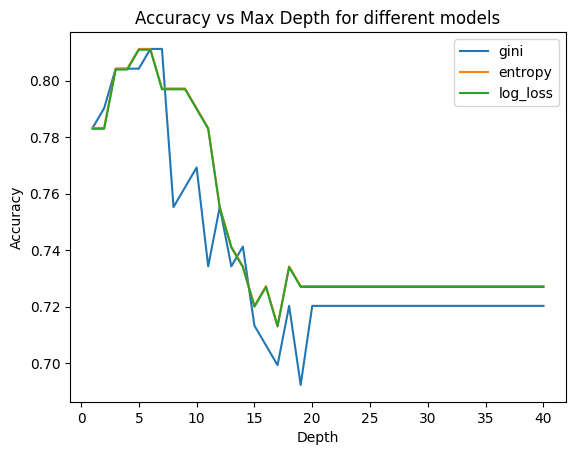

Best layers: 5 
Accuracy: 0.8111888111888111


In [27]:
plt.plot(layers, acc[0], label="gini")
plt.plot(layers, acc[1], label="entropy")
plt.plot(layers, np.array(acc[2]) - 0.0003, label="log_loss")
plt.legend()
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Max Depth for different models")
plt.show()

bestlayers = layers[np.argmax(acc[2])]
print("Best layers:", bestlayers, "\nAccuracy:", np.max(acc[2]))

It looks like entropy and log_loss are identical, so I had to shift log_loss down by a bit so both are visible on the graph (You can just barely see the sliver of orange). After about 20 layers, it looks like the accuracy stayed the same. I'll go with log_loss because it has the same peak with less layers, so it'll probably run faster. Just these two parameters alone shoots up the accuracy, about 9%.

Next, I'll test the min_samples_split and splitter parameters.

In [28]:
acc = [[],[]]
alphas = np.logspace(-10, -3, 50, base=10)

for alpha in alphas:
    model = DecisionTreeClassifier(random_state=102, criterion='entropy', max_depth=5, min_samples_split=alpha, splitter='best')
    model.fit(X_train, y_train)
    acc[0].append(accuracy(model, X_test, y_test))
    model = DecisionTreeClassifier(random_state=102, criterion='entropy', max_depth=5, min_samples_split=alpha, splitter='random')
    model.fit(X_train, y_train)
    acc[1].append(accuracy(model, X_test, y_test))

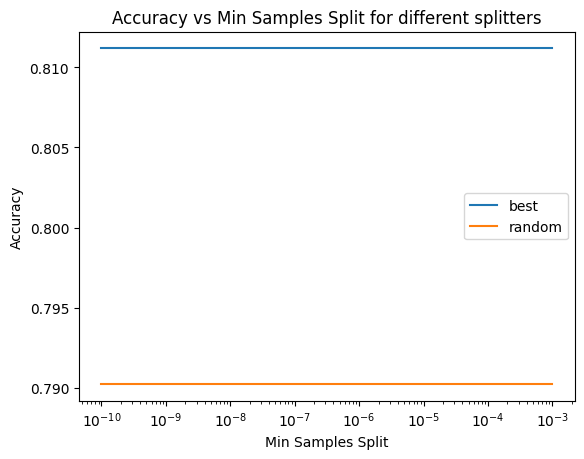

In [29]:
plt.plot(alphas, acc[0], label="best")
plt.plot(alphas, acc[1], label="random")
plt.xscale("log")
plt.legend()
plt.xlabel("Min Samples Split")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Min Samples Split for different splitters")
plt.show()

It looks like min_samples_split does nothing, and the best splitter is best. I'll test min_samples_leaf and max_leaf_nodes next.

In [30]:
maxnodes = np.unique(np.logspace(0.35, 3, 25, base=10).astype(int))
minsamples = np.logspace(-5, -0.01, 50, base=10)
acc = np.zeros((len(maxnodes), len(minsamples)))

for i in range(len(maxnodes)):
    for j in range(len(minsamples)):
        model = DecisionTreeClassifier(random_state=102, criterion='entropy', max_depth=5, min_samples_split=minsamples[j], max_leaf_nodes=maxnodes[i])
        model.fit(X_train, y_train)
        acc[i][j] = accuracy(model, X_test, y_test)

In [31]:
bestacc = np.max(acc)
am = np.argmax(acc)
bestmaxnodes = maxnodes[int(am / len(minsamples))]
bestminsamples = minsamples[am % len(minsamples)]
print("Best Max Nodes:", bestmaxnodes, "\nBest Min Samples:", bestminsamples, "\nAccuracy:", bestacc)

Best Max Nodes: 17 
Best Min Samples: 0.014352870800722006 
Accuracy: 0.8181818181818182


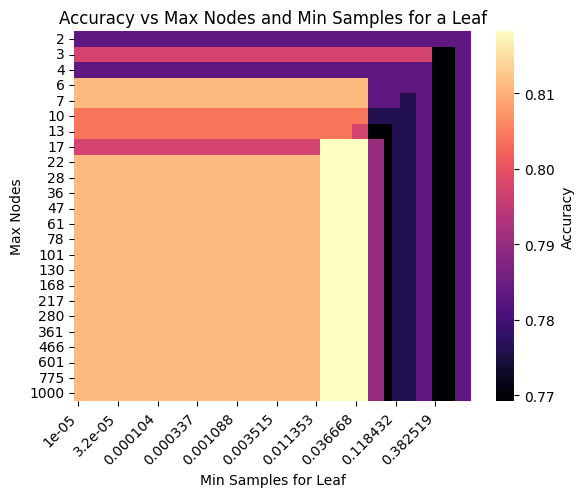

In [32]:
sns.heatmap(acc, annot=False, cmap="magma", xticklabels=np.round(minsamples, 6), yticklabels=maxnodes, cbar_kws={'label': 'Accuracy'})
plt.gca().set_xticks(plt.gca().get_xticks()[::5])
plt.title("Accuracy vs Max Nodes and Min Samples for a Leaf")
plt.xlabel("Min Samples for Leaf")
plt.ylabel("Max Nodes")
plt.xticks(rotation=45, ha="right")
plt.show()

It looks like the peak accuracy for the decision tree is 82%, with 17 max nodes, and 0.14% of the database required to make a leaf node. Here's the final model:

Accuracy:  0.8181818181818182


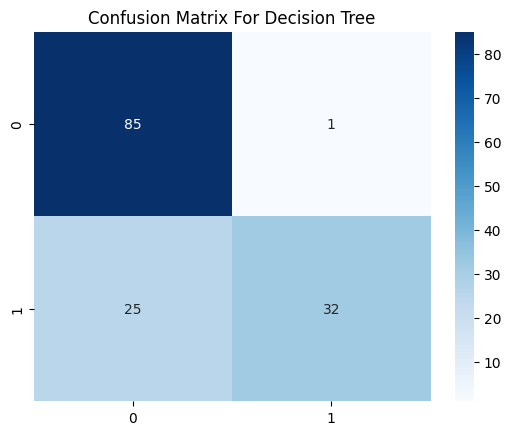

In [33]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=bestminsamples, max_leaf_nodes=bestmaxnodes, random_state=102)
model.fit(X_train, y_train)
print("Accuracy: ", accuracy(model, X_test, y_test))
cm_tree = confusion_matrix(y_test, model.predict(X_test))

plt.title("Confusion Matrix For Decision Tree")
sns.heatmap(cm_tree, annot=True, cmap="Blues")
plt.show()

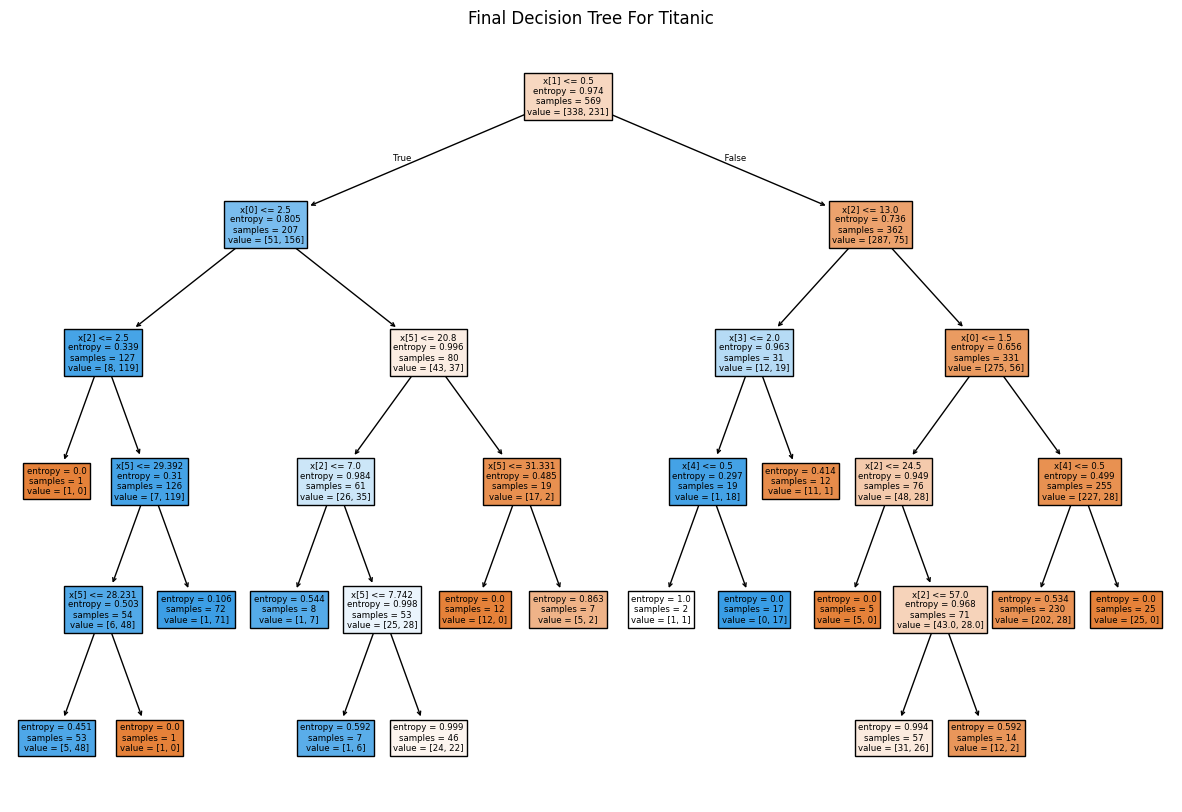

In [34]:
fig, ax = plt.subplots(figsize=(15, 10))
tree.plot_tree(model, ax=ax, filled=True)
ax.set_title("Final Decision Tree For Titanic")
plt.show()

Here's a comparison between between decision tree and logistic regression:

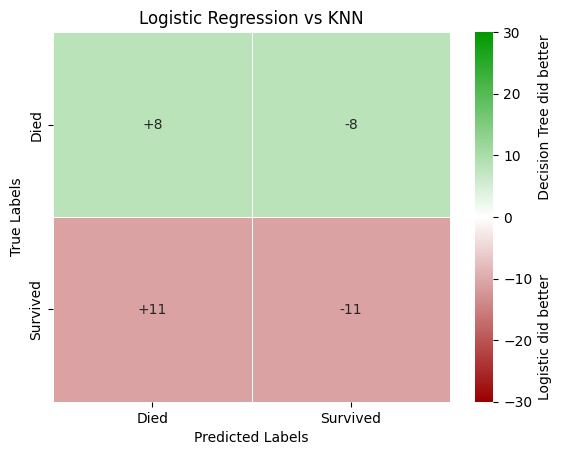

In [35]:
fig, ax = plt.subplots()
ax.set_title("Logistic Regression vs KNN")
plot_confusion_comparison(cm_log, cm_tree, ax, "Logistic did better                 Decision Tree did better")
plt.show()

So far, it looks like the decision tree is worse than logistic regression. Overall, it looks like Logistic is the best model. 

### Model Comparison

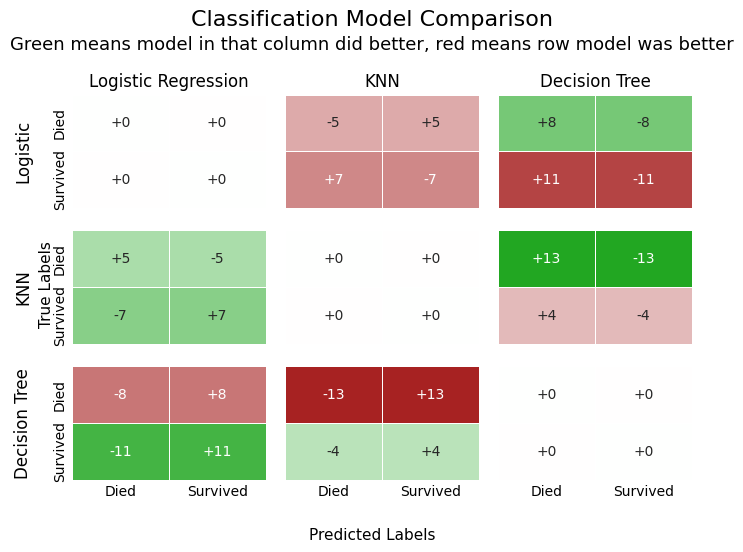

In [108]:
fig, axes = plt.subplots(3, 3, figsize=(8, 5))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

fig.suptitle("Classification Model Comparison", fontsize=16, y=1.05)
fig.text(0.5, .98, "Green means model in that column did better, red means row model was better", ha="center", va="center", fontsize=13)
fig.text(0.093, 0.5, "True Labels", ha="center", va="center", fontsize=11, rotation="vertical")
fig.text(0.5, 0, "Predicted Labels", ha="center", va="center", fontsize=11)

cms = [cm_log, cm_knn, cm_tree]
models = ["Logistic Regression", "KNN", "Decision Tree"]

axes[0][0].set_title("Logistic Regression")
axes[0][1].set_title ("KNN")
axes[0][2].set_title("Decision Tree")

axes[0][0].text(-0.5, 1, "Logistic", fontsize=12, ha="center", va="center", rotation="vertical")
axes[1][0].text(-0.5, 1, "KNN", fontsize=12, ha="center", va="center", rotation="vertical")
axes[2][0].text(-0.5, 1, "Decision Tree", fontsize=12, ha="center", va="center", rotation="vertical")


for i in range(3):
    for j in range(3):
        ax = axes[i][j]
        plot_confusion_comparison(cms[i], cms[j], ax, "", hide_bottom=(i != 2), hide_side=j != 0, colorbar=False, extra_labels=False)


Logistic Regression had the greenest column and the reddest row, so it was the overall best model. All of them were relatively close however, only differing by a handful of cases. The best accuracy achieved by the models was 84% (Only 23 people were left to drown, yay!).

Accuracy:  0.8391608391608392


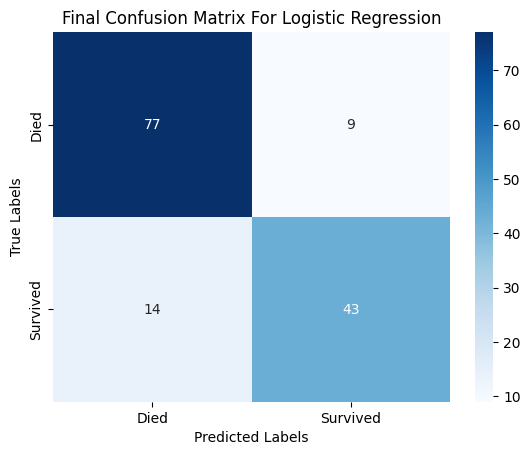

In [120]:
model = LogisticRegression(penalty=best_penalty, solver=best_solver, max_iter=best_iter, random_state=102)
model.fit(X_train, y_train)
print("Accuracy: ", accuracy(model, X_test, y_test))
cm_log = confusion_matrix(y_test, model.predict(X_test))

plt.title("Final Confusion Matrix For Logistic Regression")
ax = sns.heatmap(cm_log, annot=True, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
ax.set_xticklabels(["Died", "Survived"])
ax.set_yticklabels(["Died", "Survived"])
plt.show()